How do external factors influence students' math, reading, and writing scores? 
What features can we generate to increase the prediction of how a student will score based on other features?




** Null Hypothesis: There is no difference in scores based on selected external factors.


** Alternative Hypothesis: There is a difference in scores based on selected external factors.

# EDA

## Read in the data

In [1]:
!pip install shap 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway, ttest_ind
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
import optuna
import warnings
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)


# Load the dataset
scores = pd.read_csv("StudentPerformanceFactors.csv", sep = ",")
print(f"View Dataset:")
display(scores.head())

# Display the shape, info, and nulls
print("**********************************")
display(f"View Dataset Info:")
display(scores.info())
print("**********************************")
print(f"View Dataset Nulls: ")
display(scores.isnull().sum())
print("**********************************")
print("View Shape:")
display(scores.shape)

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View Dataset:


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


**********************************


'View Dataset Info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

None

**********************************
View Dataset Nulls: 


Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

**********************************
View Shape:


(6607, 20)

In [3]:
categorical_columns = scores.select_dtypes(include=['object']).columns
for column in categorical_columns:
    scores[column].fillna('N/A', inplace=True)
print(scores[categorical_columns].isnull().sum())

Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Motivation_Level              0
Internet_Access               0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
dtype: int64


## Explore the data

In [4]:
#Summary stats
display(f"Summary Stats:")
display(scores.describe())

#List numerical values
print(f"Numerical Values:")
print(scores.select_dtypes(include = np.number).columns)
print(f"Number of Numerical Values: {len(scores.select_dtypes(include = np.number).columns)}\n")

#List categorical values
print(f"Categorical Values:")
print(scores.select_dtypes(include = object).columns)
print(f"Number of Categorical Values: {len(scores.select_dtypes(include = object).columns)}\n")

'Summary Stats:'

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


Numerical Values:
Index(['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
       'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score'],
      dtype='object')
Number of Numerical Values: 7

Categorical Values:
Index(['Parental_Involvement', 'Access_to_Resources',
       'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access',
       'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence',
       'Learning_Disabilities', 'Parental_Education_Level',
       'Distance_from_Home', 'Gender'],
      dtype='object')
Number of Categorical Values: 13



## Select Features based on F Score and MI

In [5]:
#Select all features
features = ['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender']

#Split Data
X = scores[features]
y = scores['Exam_Score']

#Encode Cat variables
X_encoded = X.apply(LabelEncoder().fit_transform)

#ANOVA Selection
anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X_encoded, y)
anova_scores = anova_selector.scores_

#Mutual Info Selection
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X_encoded, y)
mi_scores = mi_selector.scores_

#DataFrame for analysis
feature_scores = pd.DataFrame({
    'Feature': features,
    'ANOVA_F_Score': anova_scores,
    'Mutual Information Score': mi_scores
})
display(feature_scores.sort_values(by='ANOVA_F_Score', ascending=False))


,Feature,ANOVA_F_Score,Mutual Information Score
1,Attendance,131.977457,0.300631
0,Hours_Studied,58.124454,0.162868
6,Previous_Scores,7.650978,0.015043
9,Tutoring_Sessions,6.002129,0.017775
15,Learning_Disabilities,3.260799,0.000000
3,Access_to_Resources,2.955494,0.042073
13,Peer_Influence,2.732620,0.019837
17,Distance_from_Home,2.570034,0.009778
2,Parental_Involvement,2.472846,0.022974
14,Physical_Activity,1.895696,0.000000


**FIVE VARIABLES**

Attendance - Percentage of classes attended.

Hours Studied - Number of hours spent studying per week.

Previous Scores - Scores from previous exams.

Tutoring Sessions - Number of tutoring sessions attended per month.

Learning_Disabilities - If a student has a learning disability.


## Plots

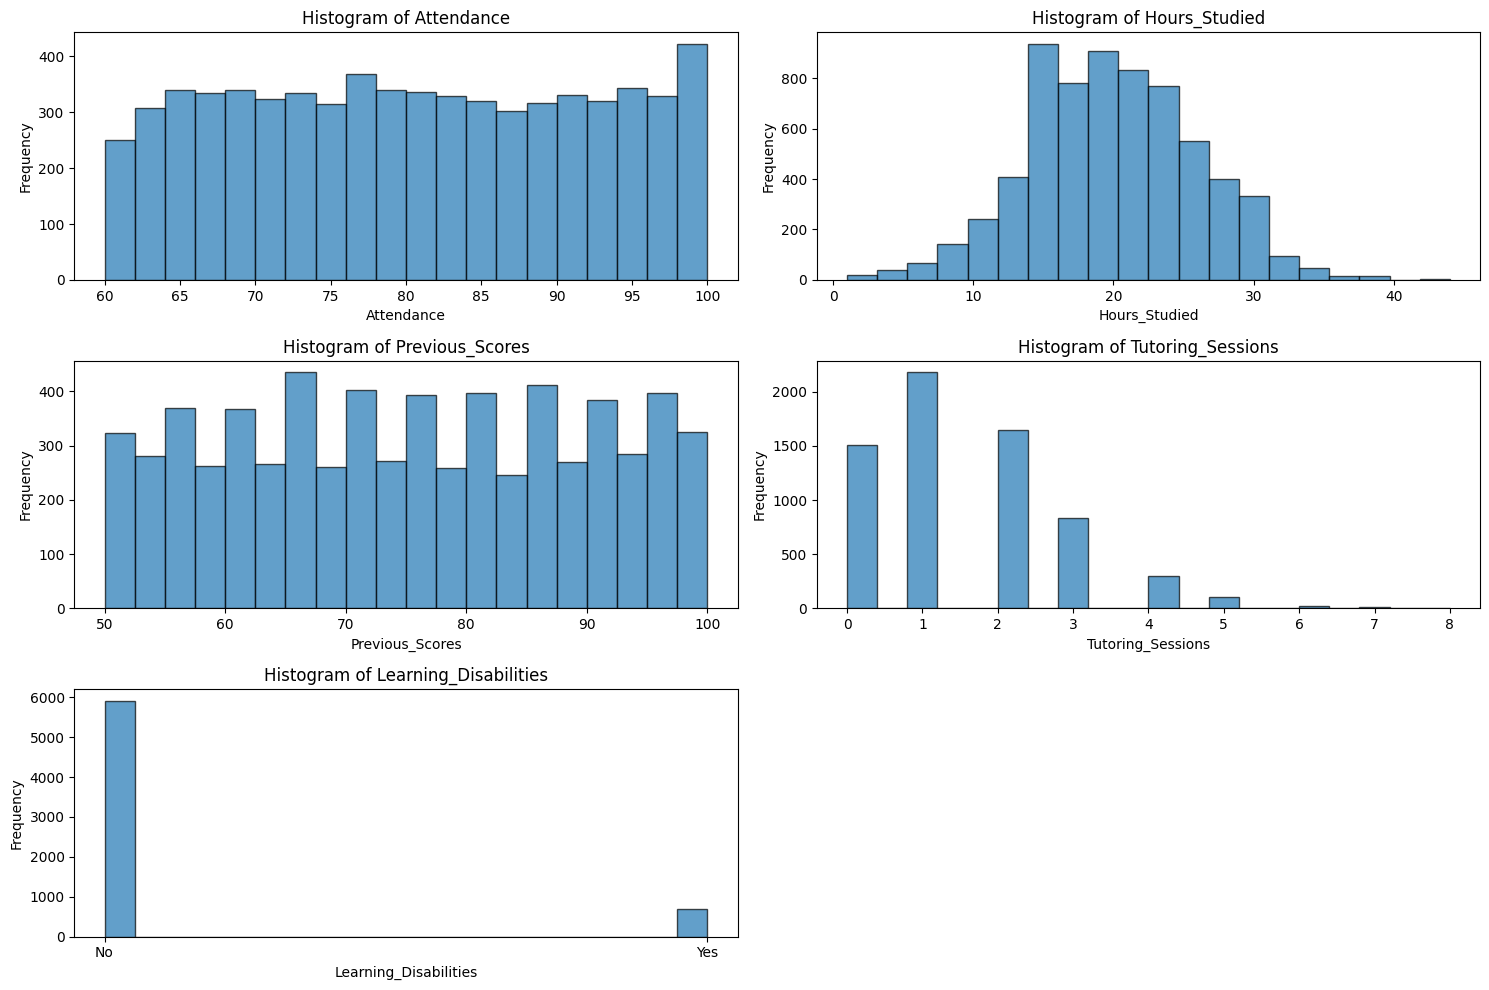

In [6]:
# Top 5 variables in ANOVA and MI
selected_variables = ["Attendance", "Hours_Studied", "Previous_Scores", "Tutoring_Sessions", "Learning_Disabilities"]

#Create an iterate through plots
plt.figure(figsize=(15, 10))
for i, var in enumerate(selected_variables, 1):
    plt.subplot(3, 2, i) 
    plt.hist(scores[var], bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


**Attendance:**

Distribution is fairly uniform that idicates that students have a varying attendance rate. There are a few outliers with some hitting at or below 60. These can be removed so to not skew the analysis but they can also be analyzed separately if needed.


**Hours Studied:**

The distribution is slightly right skewed in between 10-25 hours. There are very little near zero or above 35-40. Since that is the case if high study hours lead to lower scores then they should be dropped and examined separately.


**Previous Scores:**

Mostly uniform distribution students scoring at or near 50 may be outliers we can keep these students for further analysis and should be dropped and examined separately.


**Tutoring Sessions:**

This is right skewed and most students have between 0-2 sessions on average. we need to see that high tutoring sessions improve scores before dropping and examined separately

**Learning_Disabilities:**

This is Right Skewed with categories falling into 2. The outliers here could be Yes or no but, we need to see if that has an effect on scores before we drop them.


**Handling**

Attendance: Students with low attendance (<65%) should be analyzed separately to determine their impact on performance, and extreme cases may be removed if they skew the dataset.

Hours Studied: Excessively high study hours (>35 hours) should be capped or categorized to assess whether overstudying leads to diminishing returns.

Previous Scores: Students scoring below 55% should be examined for potential intervention needs, and performance bands can be created for clearer insights.

Tutoring Sessions: High tutoring sessions (6+ sessions) should be analyzed to determine if they improve performance or indicate struggling students.

Learning_Disabilites: Students with L.D should be monitored individually to assess impact.



## Variable information

In [7]:
#Encode Parental_Involvement for this analysis
scores["Learning_Disabilities"] = scores["Learning_Disabilities"].astype("category").cat.codes
# Mean, Mode, Spread and tails for selected variables
for var in selected_variables:
    print(f"Variable: {var}")
    print(f"Mean: {scores[var].mean()}")
    print(f"Mode: {scores[var].mode()[0]}")
    print(f"Standard Deviation: {scores[var].std()}")
    print(f"Skewness: {scores[var].skew()}")
    print(f"Kurtosis: {scores[var].kurtosis()}")
    print(f"Shape of the variable: {scores[var].shape}")
    print("\n")

Variable: Attendance
Mean: 79.97744816104132
Mode: 67
Standard Deviation: 11.547474961482814
Skewness: 0.013665859547014896
Kurtosis: -1.1944066537666138
Shape of the variable: (6607,)


Variable: Hours_Studied
Mean: 19.975329196306948
Mode: 20
Standard Deviation: 5.9905943365787415
Skewness: 0.013498908859762987
Kurtosis: 0.017770627289391605
Shape of the variable: (6607,)


Variable: Previous_Scores
Mean: 75.07053125472983
Mode: 66
Standard Deviation: 14.399784350759024
Skewness: -0.00373653379826588
Kurtosis: -1.1910804118343832
Shape of the variable: (6607,)


Variable: Tutoring_Sessions
Mean: 1.4937187831088239
Mode: 1
Standard Deviation: 1.2305704213240194
Skewness: 0.8155296028773414
Kurtosis: 0.6437183161753812
Shape of the variable: (6607,)


Variable: Learning_Disabilities
Mean: 0.10519146359921296
Mode: 0
Standard Deviation: 0.3068231871619583
Skewness: 2.5743040376918414
Kurtosis: 4.628442259168562
Shape of the variable: (6607,)




## PMF

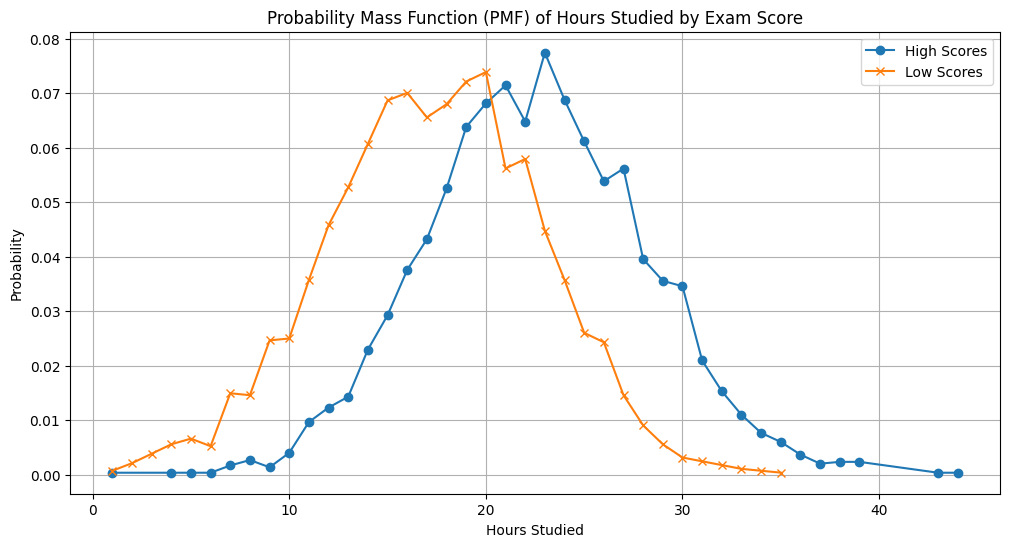

In [8]:
#We will segment the scores based on median splitting so that we can have high scores and low scores

#PMF for the variable 'Hours_Studied' for students with high exam scores
high_scores = scores[scores['Exam_Score'] > scores['Exam_Score'].median()]
pmf_high_scores = high_scores['Hours_Studied'].value_counts(normalize=True).sort_index()

#PMF for the variable 'Hours_Studied' for students with low exam scores
low_scores = scores[scores['Exam_Score'] < scores['Exam_Score'].median()]
pmf_low_scores = low_scores['Hours_Studied'].value_counts(normalize=True).sort_index()

# Plot the PMFs
plt.figure(figsize=(12, 6))
plt.plot(pmf_high_scores, label='High Scores', marker='o')
plt.plot(pmf_low_scores, label='Low Scores', marker='x')
plt.xlabel('Hours Studied')
plt.ylabel('Probability')
plt.title('Probability Mass Function (PMF) of Hours Studied by Exam Score')
plt.legend()
plt.grid(True)
plt.show()


The PMF chart shows that students who study 10-20 hours have the highest probability of receiving low scores, while those studying 20-30 hours have the highest probability of achieving high scores. As study hours increase beyond 30 hours, the probability of high scores starts to decline, suggesting diminishing returns from excessive studying. Low scores are rare beyond 30 hours of study, indicating that a minimum effort is required for success. The data suggests that 20-30 study hours is the optimal range, whereas studying less than 10 hours significantly increases the likelihood of low scores. Overall, while more study hours generally improve performance, overstudying beyond 35-40 hours does not guarantee better results and may even have negative effects.

## CDF

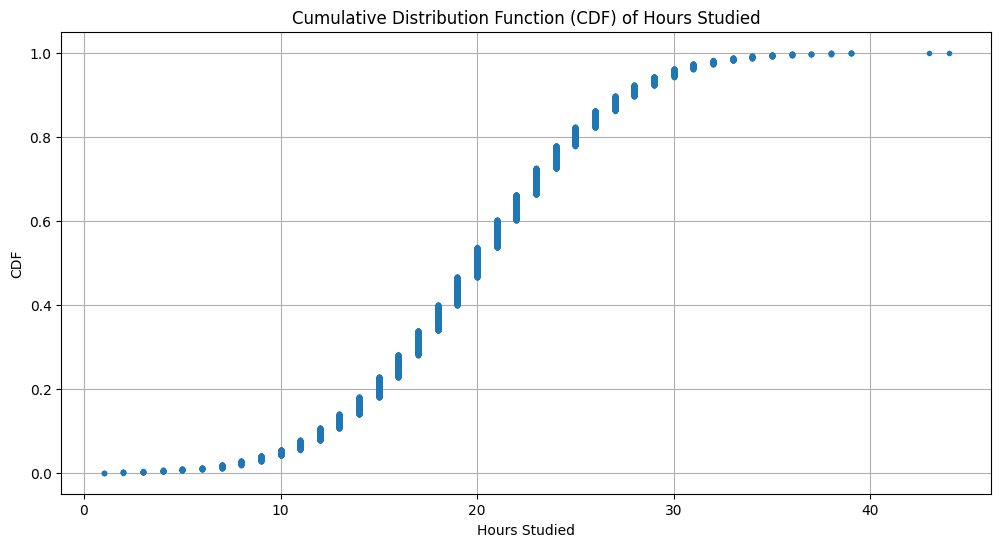

In [9]:
#Examine all Students 

# Create a CDF for the variable 'Hours_Studied'
x = np.sort(scores['Hours_Studied'])
y = np.arange(1, len(x) + 1) / len(x)

# Plot the CDF
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Hours Studied')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Hours Studied')
plt.grid(True)
plt.show()


The CDF of hours studied shows that half of the students study less than 20 hours, indicating this as the median study time. The steepest increase occurs between 10-30 hours, meaning most students fall within this range. After 30 hours, the curve flattens, suggesting that very few students study beyond this point. The plateau near 1.0 confirms that nearly all students study at most 40-45 hours. This distribution highlights that analyzing performance in the 10-30 hour range is most relevant, as extreme study hours are uncommon.

## Hypothesis testing

In [10]:
#Create bins for ANOVA
def feature_bins(df):
    df = df.copy()

    df['Attendance_Bin'] = pd.qcut(df['Attendance'], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])
    df['Hours_Studied_Bin'] = pd.qcut(df['Hours_Studied'], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])
    df['Previous_Scores_Bin'] = pd.qcut(df['Previous_Scores'], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])
    df['Tutoring_Sessions_Bin'] = df['Tutoring_Sessions']
    df['Learning_Disabilities_Bin'] = df['Learning_Disabilities']

    return df

#ANOVA Oneway
def anova_oneway(df):
    anova_results = {}
    
    for var in ['Attendance_Bin', 'Hours_Studied_Bin', 'Previous_Scores_Bin', 'Tutoring_Sessions_Bin', 'Learning_Disabilities_Bin']:
        groups = [df['Exam_Score'][df[var] == level] for level in df[var].unique()]  # Use 'df' instead of 'df_clean'
        f_stat, p_value = stats.f_oneway(*groups)
        anova_results[var] = {'F-Statistic': f_stat, 'p-value': p_value}
    
    return pd.DataFrame(anova_results).T


#run defs
df_clean = scores.dropna(subset=['Exam_Score', 'Attendance', 'Hours_Studied', 'Previous_Scores', 
                              'Tutoring_Sessions', 'Learning_Disabilities'])
df_clean = feature_bins(df_clean)
anova = anova_oneway(df_clean)

    
display(anova)


,F-Statistic,p-value
Attendance_Bin,998.795522,0.000000e+00
Hours_Studied_Bin,469.680145,1.266774e-276
Previous_Scores_Bin,68.815600,8.165416e-44
Tutoring_Sessions_Bin,21.807736,4.304699e-33
Learning_Disabilities_Bin,48.143389,4.338624e-12


### Correlations

In [11]:
# Calculate Pearson correlation coefficients
correlations = df_clean[['Exam_Score', 'Attendance', 'Hours_Studied', 'Previous_Scores', 
                              'Tutoring_Sessions', 'Learning_Disabilities']].corr()

# Display correlation matrix
display(correlations)


,Exam_Score,Attendance,Hours_Studied,Previous_Scores,Tutoring_Sessions,Learning_Disabilities
Exam_Score,1.000000,0.581072,0.445455,0.175079,0.156525,-0.085066
Attendance,0.581072,1.000000,-0.009908,-0.020186,0.014324,-0.022231
Hours_Studied,0.445455,-0.009908,1.000000,0.024846,-0.014282,-0.014401
Previous_Scores,0.175079,-0.020186,0.024846,1.000000,-0.013122,0.007057
Tutoring_Sessions,0.156525,0.014324,-0.014282,-0.013122,1.000000,0.007564
Learning_Disabilities,-0.085066,-0.022231,-0.014401,0.007057,0.007564,1.000000


### Scatter plots / Distribution

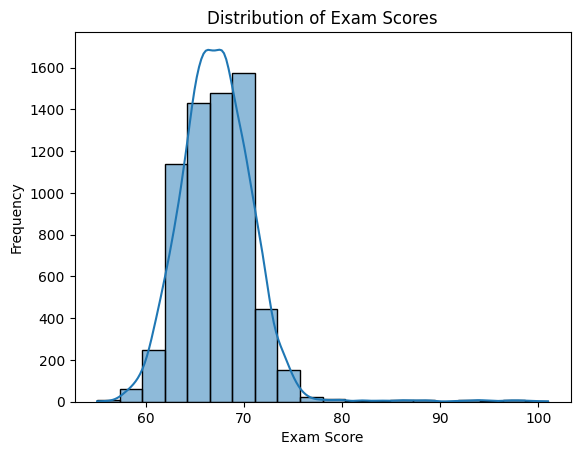

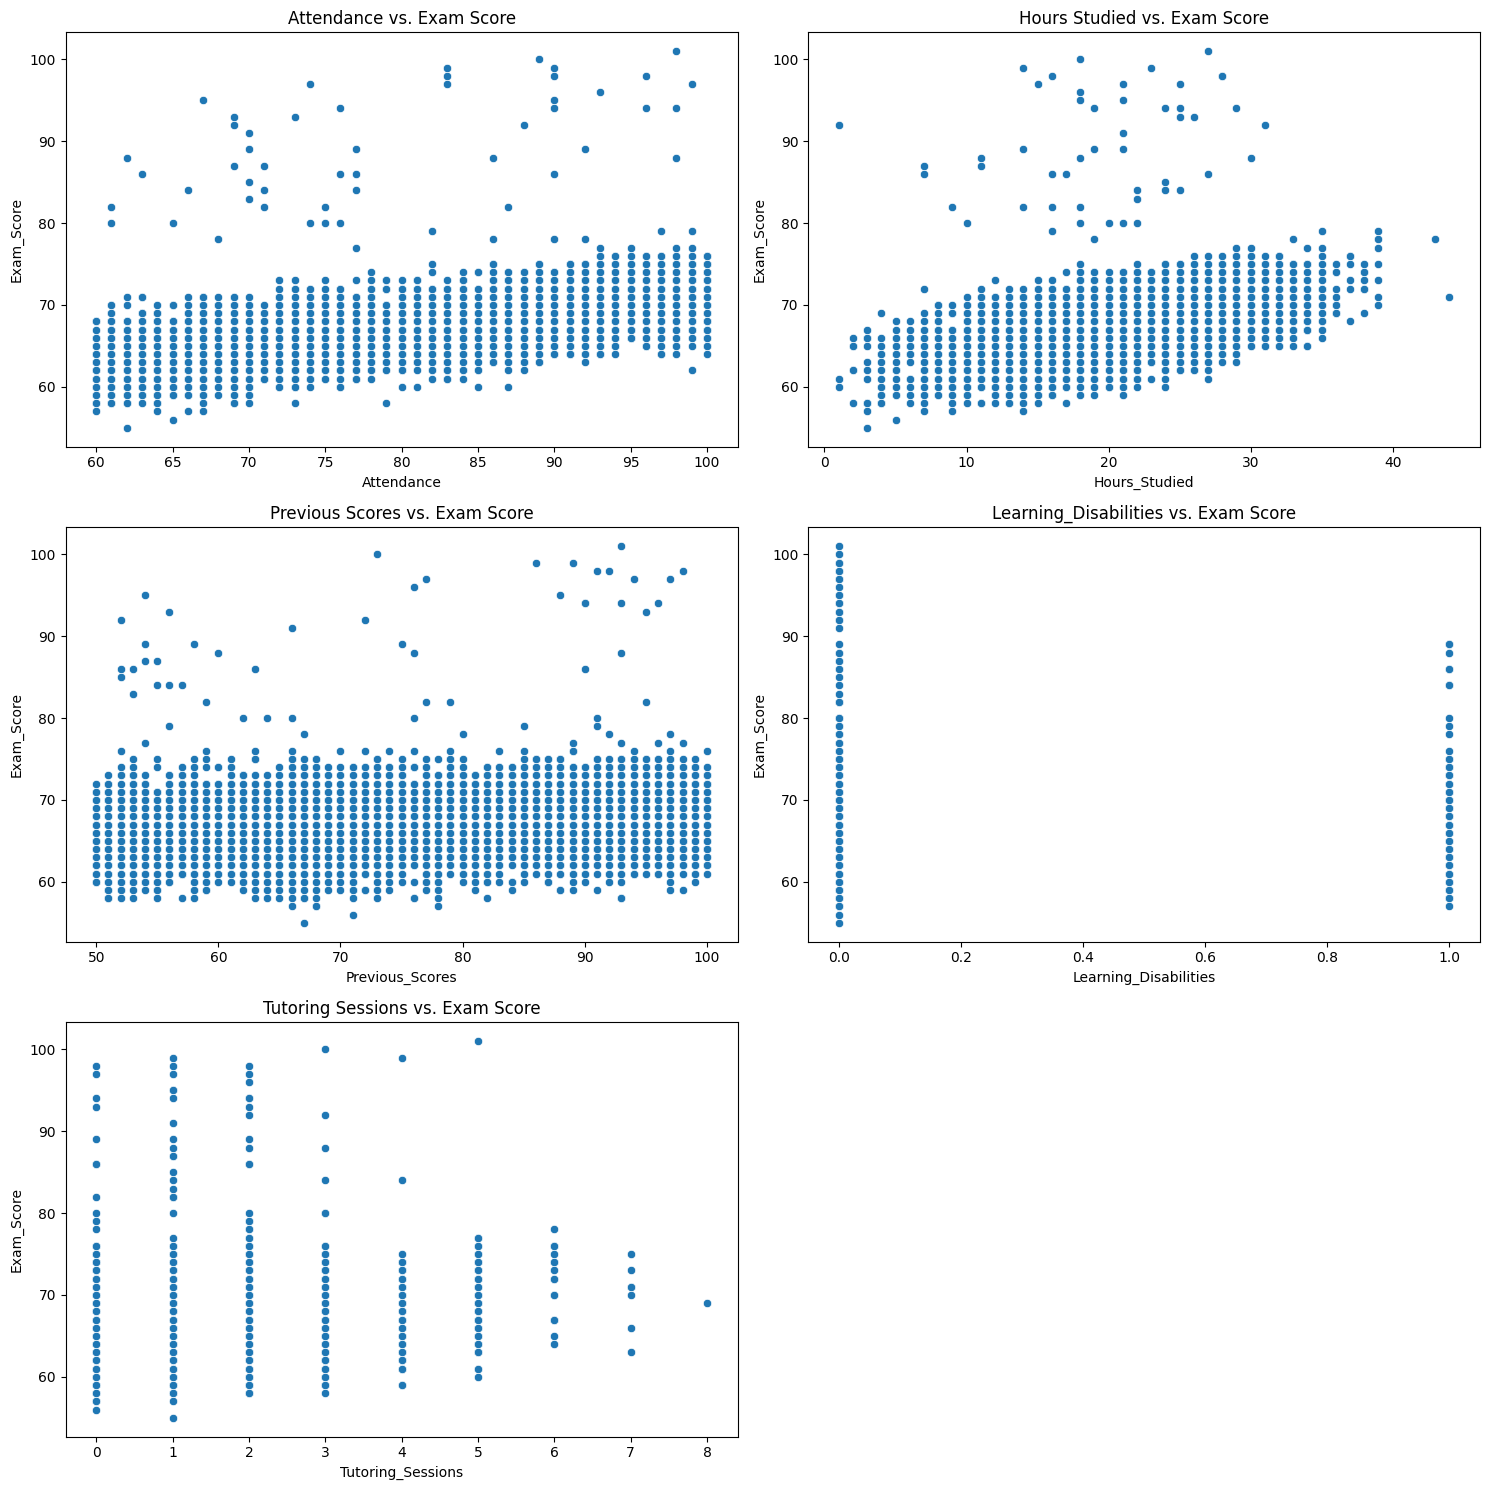

In [12]:
#Plot Dist
sns.histplot(df_clean['Exam_Score'], kde=True, bins=20)
plt.title("Distribution of Exam Scores")
plt.xlabel("Exam Score")
plt.ylabel("Frequency")
plt.show()

# Scatter plots for variables vs. Exam Score
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Attendance vs. Exam Score
sns.scatterplot(x=df_clean['Attendance'], y=df_clean['Exam_Score'], ax=axes[0, 0])
axes[0, 0].set_title("Attendance vs. Exam Score")

# Hours Studied vs. Exam Score
sns.scatterplot(x=df_clean['Hours_Studied'], y=df_clean['Exam_Score'], ax=axes[0, 1])
axes[0, 1].set_title("Hours Studied vs. Exam Score")

# Previous Scores vs. Exam Score
sns.scatterplot(x=df_clean['Previous_Scores'], y=df_clean['Exam_Score'], ax=axes[1, 0])
axes[1, 0].set_title("Previous Scores vs. Exam Score")

# Physical Activity vs. Exam Score
sns.scatterplot(x=df_clean['Learning_Disabilities'], y=df_clean['Exam_Score'], ax=axes[1, 1])
axes[1, 1].set_title("Learning_Disabilities vs. Exam Score")

# Tutoring Sessions vs. Exam Score
sns.scatterplot(x=df_clean['Tutoring_Sessions'], y=df_clean['Exam_Score'], ax=axes[2, 0])
axes[2, 0].set_title("Tutoring Sessions vs. Exam Score")

# Hide the empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()


In [13]:
#Shapiro-Wilk
from scipy.stats import shapiro
stat, p = shapiro(df_clean['Exam_Score'])
print("Shapiro-Wilk Test Statistic: {:.4f}".format(stat))
print("p-value: {:.4f}".format(p))

Shapiro-Wilk Test Statistic: 0.9029
p-value: 0.0000


1. **Attendance vs. Exam Score**

Positive correlation: As attendance increases, exam scores generally improve.
Dense clustering between 60-80 scores: Most students fall in this range.
Some high outliers: A few students with high attendance (>90%) score near 100, suggesting that consistency in attendance helps.

2. **Hours Studied vs. Exam Score**

Positive correlation: More study hours lead to higher exam scores.
Wide variance: Some students who study less still score high, implying other factors (like tutoring or past performance) may contribute.
Upper outliers: A few students with 40+ hours of study score near 100, reinforcing the importance of study time.

3. **Previous Scores vs. Exam Score**

Weak correlation: While students with higher previous scores tend to do better, there is a lot of spread.
Dense clusters around 60-80: Past performance influences current scores but is not the only determinant.

4. **Learning_Disabilities vs. Exam Score**

Weak correlation: Learning_Disabilities does not show a strong correlation with exam scores.
Categorical nature: Learning_Disabilities levels appear discrete (Yes, No).
Possible indirect effects: While exercise may improve focus, other variables (like study time) have stronger direct effects on scores.

5. **Tutoring Sessions vs. Exam Score**

Weak correlation: More tutoring sessions doesn't always result in higher scores.
Wide variance: Some students with zero tutoring still score high, implying that tutoring helps but is not mandatory for high performance.
Potential diminishing returns: After 4+ tutoring sessions, the improvement slows, meaning quality of tutoring may matter more than quantity.

## STATS

### Linear Regression


Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     1247.
Date:                Wed, 26 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:25:20   Log-Likelihood:                -12388.
No. Observations:                5285   AIC:                         2.479e+04
Df Residuals:                    5278   BIC:                         2.484e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const             

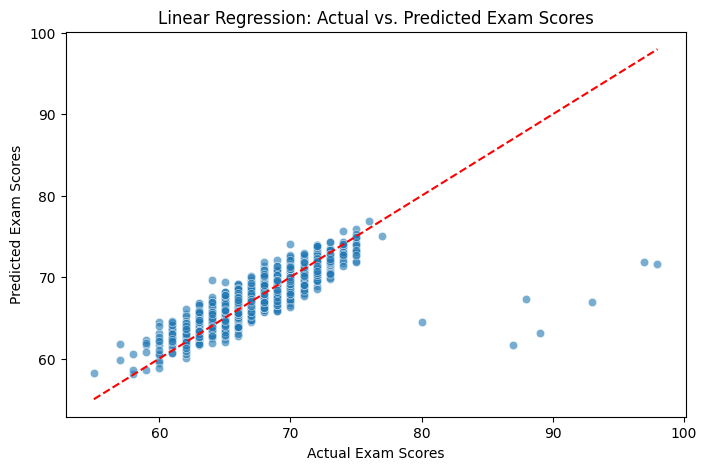

In [14]:
#Redoing feature binning for linear reg analysis and adding two features
def feature_engineering(df, train_bins=None):
    df = df.copy()
    if train_bins is None:
        bins_attendance = pd.qcut(df['Attendance'], q=4, labels=[1, 2, 3, 4], retbins=True)[1]
        bins_hours = pd.qcut(df['Hours_Studied'], q=4, labels=[1, 2, 3, 4], retbins=True)[1]
        train_bins = {'bins_attendance': bins_attendance, 'bins_hours': bins_hours}
    df['Study_Efficiency'] = np.log1p(df['Attendance'] + df['Hours_Studied'])
    df['PrevScores_Tutoring'] = df['Previous_Scores'] * df['Tutoring_Sessions']

    return df, train_bins


def linear_regression(X_train, X_test, y_train, y_test):
    #Get copys of train and test dfs
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    #Add Constant for OLS
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    #Train OLS Regression
    model = sm.OLS(y_train, X_train).fit()
    print("\nModel Summary:")
    print(model.summary())

    #Predictions
    y_pred = model.predict(X_test)

    #Model Evaluation Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    acc = 100 - mape
    mbe = np.mean(y_pred - y_test)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel Performance Metrics:")
    print(f"MAPE: {mape:.4f}%")
    print(f"Accuracy: {acc:.4f}")
    print(f"Bias: {mbe:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2: {r2:.4f}")

    # Scatter plot of Linear Regression
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color='red')
    plt.xlabel("Actual Exam Scores")
    plt.ylabel("Predicted Exam Scores")
    plt.title("Linear Regression: Actual vs. Predicted Exam Scores")
    plt.show()

    return model, y_pred

######################################################################################

#Select cols
X = df_clean[['Attendance', 'Hours_Studied', 'Previous_Scores', 'Tutoring_Sessions']]
y = df_clean['Exam_Score']  

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Apply feature_engineering
X_train, train_bins = feature_engineering(X_train)
X_test, _ = feature_engineering(X_test, train_bins)

#Apply linear_regression
model, y_pred = linear_regression(X_train, X_test, y_train, y_test)


# Additional Analysis

## Segmentation

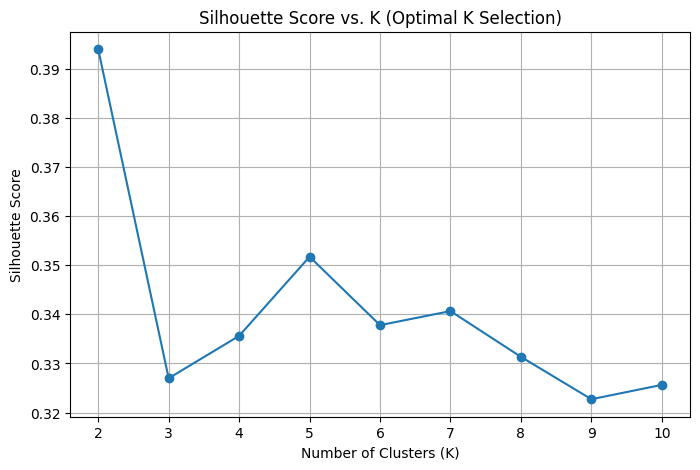

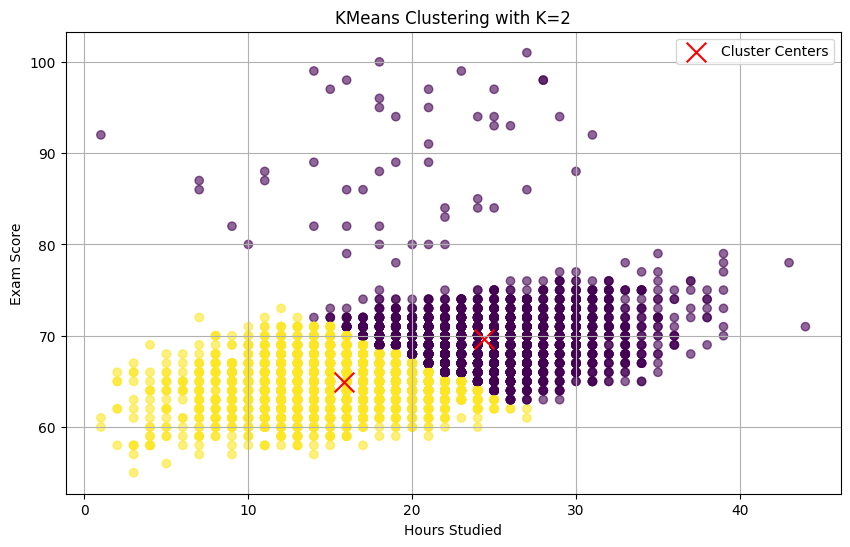

In [15]:
def find_optimal_k(Z, k_min = 2, k_max = 10):
    #Apply K-Means
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    k_values = range(k_min, k_max + 1)
    silhouette_scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
        kmeans.fit(X_scaled)
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)

    # Find the best K
    best_k = k_values[np.argmax(silhouette_scores)]

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. K (Optimal K Selection)')
    plt.grid(True)
    plt.show()
    return best_k, silhouette_scores

def k_means_clustering(X,k):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    centers = kmeans.cluster_centers_
    centers_original = scaler.inverse_transform(centers)

    # Plot 
    plt.figure(figsize=(10, 6))
    plt.scatter(X['Hours_Studied'], X['Exam_Score'], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(
        centers_original[:, 0], centers_original[:, 1],
        c='red', marker='x', s=200, label='Cluster Centers'
    )
    plt.xlabel('Hours Studied')
    plt.ylabel('Exam Score')
    plt.title(f'KMeans Clustering with K={k}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return labels, centers_original

#Apply Segmentation and clustering
X = df_clean[['Hours_Studied', 'Exam_Score']]
optimal_k, silhouette_scores = find_optimal_k(X, k_min=2, k_max=10)
labels, centers = k_means_clustering(X, optimal_k)


## Hyperparamter tuning

In [16]:
#Set up data
df_clean['Cluster'] = labels
categorical_features = df_clean.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le  

#Define parameters to search through
def objective(trial, X_train, y_train, X_val, y_val):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'random_state': 1
    }
    
    #Create model for the Hyperparameter tuning with validation metrics
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse


#Perform Hyperparameter tuning by cluster
cluster_results = []

for cluster_id, cluster_data in df_clean.groupby('Cluster'):
    print(f"\nProcessing Cluster: {cluster_id}")
    X = cluster_data.drop(columns=['Exam_Score', 'Cluster'])
    y = cluster_data['Exam_Score']
    
    #Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    lgbm = LGBMRegressor(random_state=1)
    lgbm.fit(X_train, y_train)
    
    #Collect feature importances with the trained models and take only top features
    feature_importances = lgbm.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    top_features = feature_importance_df[feature_importance_df['Importance'] > 0]['Feature'].tolist()
    X_train = X_train[top_features]
    X_val = X_val[top_features]
    print(f"Top Features for Cluster {cluster_id}: {top_features}")

    #Utilize optuna study to minimize mean squared error
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=20, show_progress_bar=True)

    #Store best parameters 
    best_params = study.best_params
    print(f"Best Hyperparameters for Cluster {cluster_id}: {best_params}")
    
    #Store the results
    cluster_results.append({
        'Cluster': cluster_id,
        'Best Hyperparameters': best_params,
        'Top Features': top_features
    })


cluster_results_df = pd.DataFrame(cluster_results)
display(cluster_results_df)



Processing Cluster: 0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 24
[LightGBM] [Info] Start training from score 69.656617
Top Features for Cluster 0: ['Hours_Studied', 'Previous_Scores', 'Attendance', 'Tutoring_Sessions', 'Parental_Involvement', 'Sleep_Hours', 'Physical_Activity', 'Parental_Education_Level', 'Access_to_Resources', 'Family_Income', 'Motivation_Level', 'Distance_from_Home', 'Peer_Influence', 'Teacher_Quality', 'Gender', 'Extracurricular_Activities', 'Learning_Disabilities', 'Internet_Access', 'School_Type']


Best trial: 3. Best value: 8.89099:  15%|█▌        | 3/20 [00:00<00:00, 28.71it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 19
[LightGBM] [Info] Start training from score 69.656617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Best trial: 3. Best value: 8.89099:  20%|██        | 4/20 [00:00<00:00, 28.71it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

Best trial: 5. Best value: 8.5067:  50%|█████     | 10/20 [00:00<00:00, 28.13it/s]


[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 19
[LightGBM] [Info] Start training from score 69.656617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Best trial: 5. Best value: 8.5067:  65%|██████▌   | 13/20 [00:00<00:00, 23.75it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 19
[LightGBM] [Info] Start training from score 69.656617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Best trial: 5. Best value: 8.5067:  75%|███████▌  | 15/20 [00:00<00:00, 23.75it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 19
[LightGBM] [Info] Start training from score 69.656617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 19
[LightGBM] [Info] Start training from score 69.656617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 18. Best value: 8.37945:  90%|█████████ | 18/20 [00:00<00:00, 17.81it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 19
[LightGBM] [Info] Start training from score 69.656617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Best trial: 18. Best value: 8.37945: 100%|██████████| 20/20 [00:01<00:00, 19.01it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Hyperparameters for Cluster 0: {'learning_rate': 0.05519121028296871, 'num_leaves': 86, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.8966546878253225, 'colsamp

Best trial: 0. Best value: 0.514526:   5%|▌         | 1/20 [00:00<00:01, 10.26it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Warning] No further splits w

Best trial: 0. Best value: 0.514526:  15%|█▌        | 3/20 [00:00<00:00, 20.90it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 6. Best value: 0.338817:  40%|████      | 8/20 [00:00<00:00, 27.99it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Best trial: 9. Best value: 0.313042:  55%|█████▌    | 11/20 [00:00<00:00, 30.28it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Best trial: 9. Best value: 0.313042:  65%|██████▌   | 13/20 [00:00<00:00, 30.28it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Best trial: 9. Best value: 0.313042:  75%|███████▌  | 15/20 [00:00<00:00, 26.52it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 9. Best value: 0.313042:  90%|█████████ | 18/20 [00:00<00:00, 25.49it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Best trial: 9. Best value: 0.313042: 100%|██████████| 20/20 [00:00<00:00, 25.89it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 2731, number of used features: 19
[LightGBM] [Info] Start training from score 64.956426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

,Cluster,Best Hyperparameters,Top Features
0,0,"{'learning_rate': 0.05519121028296871, 'num_le...","[Hours_Studied, Previous_Scores, Attendance, T..."
1,1,"{'learning_rate': 0.20101961066963356, 'num_le...","[Hours_Studied, Attendance, Previous_Scores, T..."


## Predictions

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 19
[LightGBM] [Info] Start training from score 69.656617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 19
[LightGBM] [Info] Start training from score 69.717698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

,Cluster,MAPE,Accuracy (%),Bias,First Features,Num Features
0,0,1.540928,98.459072,-0.022249,"[Hours_Studied, Previous_Scores, Attendance, T...",19
1,1,0.682061,99.317939,-0.002646,"[Hours_Studied, Attendance, Previous_Scores, T...",19


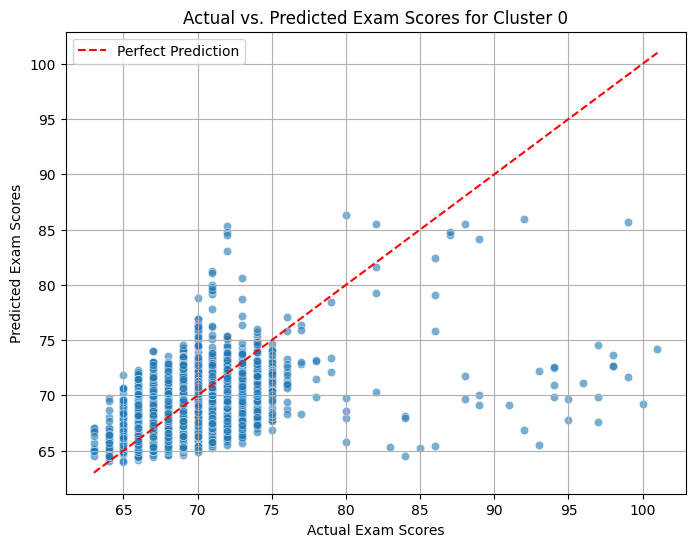

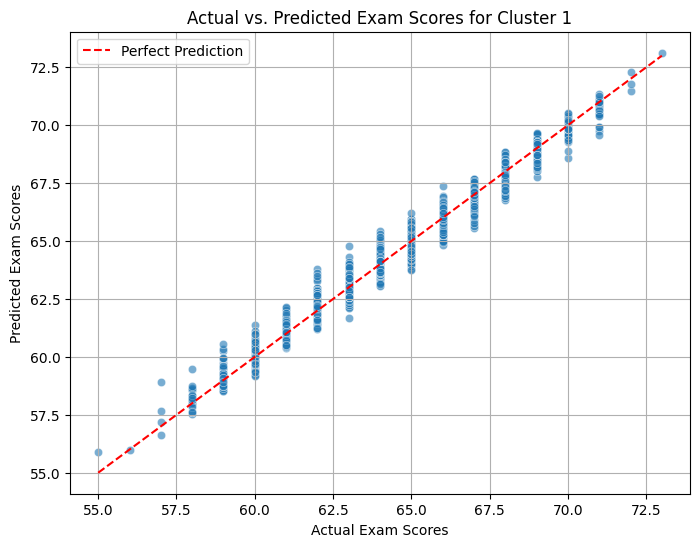

In [17]:
#K-Fold Validation 
kf = KFold(n_splits=5, shuffle=True, random_state=1)
trained_models = []
cluster_results = []


#LGBM Process
for _, row in cluster_results_df.iterrows():
    cluster_id = int(row['Cluster'])
    best_params = row['Best Hyperparameters']
    selected_features = row['Top Features']

    if isinstance(selected_features, str):
        selected_features = ast.literal_eval(selected_features)

    cluster_data = df_clean[df_clean['Cluster'] == cluster_id]
    X, y = cluster_data[selected_features], cluster_data['Exam_Score']
    num_feats = len(selected_features)
    first_feat = selected_features[:5]
    all_actual, all_pred = [], []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LGBMRegressor(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_actual.extend(y_test)
        all_pred.extend(y_pred)

    mape = np.mean(np.abs((np.array(all_actual) - np.array(all_pred)) / np.array(all_actual))) * 100
    accuracy = 100 - mape
    bias = np.mean(np.array(all_pred) - np.array(all_actual))

    trained_models.append((cluster_id, model))
    cluster_results.append({'Cluster': cluster_id, 'MAPE': mape, 'Accuracy (%)': accuracy, 'Bias': bias, 'First Features':first_feat, 'Num Features': num_feats})

    print(f"[Cluster {cluster_id}] Accuracy: {accuracy:.2f}% | Bias: {bias:.2f}")


cluster_results_df_x = pd.DataFrame(cluster_results)
display(cluster_results_df_x)

#Plots
for cluster_id, model in trained_models:
    cluster_data = df_clean[df_clean['Cluster'] == cluster_id]
    X = cluster_data[selected_features]
    y_actual = cluster_data['Exam_Score']
    
    y_pred = model.predict(X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_actual, y=y_pred, alpha=0.6)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], linestyle='dashed', color='red', label="Perfect Prediction")
    plt.xlabel("Actual Exam Scores")
    plt.ylabel("Predicted Exam Scores")
    plt.title(f"Actual vs. Predicted Exam Scores for Cluster {cluster_id}")
    plt.legend()
    plt.grid(True)
    plt.show()





In [21]:
##################################################################################
#                                                                                #
#                                                                                #
#                                                                                #
#                                                                                #
#                                WORK IN PROGRESS                                #
#                                                                                #
#                                                                                #
#                                                                                #
##################################################################################

import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

#Convert categorical columns to numerical values before training
categorical_columns = df_clean.select_dtypes(include=['category']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

feature_names = df_clean.columns.drop(['Exam_Score', 'Cluster']).tolist()

#Define controllable and non-controllable features
controllable_features = ["Hours_Studied", "Sleep_Hours", "Tutoring_Sessions", "Physical_Activity", "Extracurricular_Activities"]
non_controllable_features = [feature for feature in feature_names if feature not in controllable_features]

#Define improvement tips
improvement_tips = {
    "Hours_Studied": "Increase or decrease study hours as needed to maximize improvement.",
    "Sleep_Hours": "Balance sleep strategically for better focus.",
    "Tutoring_Sessions": "Consider adding or reducing tutoring sessions based on efficiency.",
    "Physical_Activity": "Optimize exercise for better cognitive performance.",
    "Extracurricular_Activities": "Adjust extracurriculars to best support academic goals."
}

class StudentScoreRecommender:
    def __init__(self, cluster_results_df, cluster_model, feature_names, df_clean, controllable_features, improvement_tips):
        self.cluster_results_df = cluster_results_df
        self.cluster_model = cluster_model
        self.feature_names = feature_names
        self.df_clean = df_clean
        self.trained_models = self.load_trained_models()
        self.controllable_features = controllable_features
        self.improvement_tips = improvement_tips
        self._student_cluster = None  # Store student cluster for single-use printing

    def load_trained_models(self):
        trained_models = {}
        for _, row in self.cluster_results_df.iterrows():
            cluster_id = int(row['Cluster'])
            best_params = row['Best Hyperparameters']
            selected_features = row['Top Features']

            if isinstance(selected_features, str):
                selected_features = ast.literal_eval(selected_features)

            cluster_data = self.df_clean[self.df_clean['Cluster'] == cluster_id]
            X, y = cluster_data[self.feature_names], cluster_data['Exam_Score']

            model = lgb.LGBMRegressor(**best_params, verbose=-1)
            model.fit(X, y)
            trained_models[cluster_id] = model

        return trained_models

    def segment_student(self, student_data):
        if self._student_cluster is None:
            df = pd.DataFrame([student_data], columns=self.feature_names)
            self._student_cluster = self.cluster_model.predict(df)[0]
            print(f"Student is in Cluster {self._student_cluster}")
        return self._student_cluster

    def predict(self, student_data):
        cluster = self.segment_student(student_data)
        model = self.trained_models.get(cluster)

        if model is None:
            return "No trained model found for this cluster."

        df = pd.DataFrame([student_data], columns=self.feature_names)
        return model.predict(df)[0]

    def recommend_best_score(self, student_data):
        current_score = self.predict(student_data)
        if isinstance(current_score, str):
            return current_score

        previous_score = student_data[self.feature_names.index("Previous_Scores")]
        best_score = max(current_score, previous_score)
        recommendations = []

        cluster = self.segment_student(student_data)
        model = self.trained_models.get(cluster)

        if model is None:
            return "No trained model found for this cluster."

        explainer = shap.Explainer(model)
        shap_values = explainer(pd.DataFrame([student_data], columns=self.feature_names))
        feature_importances = np.abs(shap_values.values).flatten()
        sorted_features = np.argsort(feature_importances)[::-1]

        new_student_data = student_data.copy()
        step_factor = 0.1
        adjusted_features = set()

        max_values = {"Sleep_Hours": 10, "Hours_Studied": 40, "Tutoring_Sessions": 10, "Physical_Activity": 7}
        min_values = {"Sleep_Hours": 4, "Hours_Studied": 5, "Tutoring_Sessions": 0, "Physical_Activity": 0}

        for _ in range(2000): 
            for feature_idx in sorted_features:
                feature_name = self.feature_names[feature_idx]

                if feature_name not in self.controllable_features or feature_name in adjusted_features:
                    continue

                for change in [step_factor, -step_factor]:
                    temp_student_data = new_student_data.copy()
                    new_value = temp_student_data[feature_idx] + (temp_student_data[feature_idx] * change)
                    new_value = round(new_value, 2)

                    # Apply limits
                    new_value = max(min_values.get(feature_name, -np.inf), min(new_value, max_values.get(feature_name, np.inf)))

                    temp_student_data[feature_idx] = new_value
                    new_score = self.predict(temp_student_data)

                    if new_score > best_score and new_score > previous_score:
                        best_score = new_score
                        recommendations.append(
                            f"Change {feature_name} from {student_data[feature_idx]} to {new_value} - {self.improvement_tips.get(feature_name, 'Optimize this area.')}"
                        )
                        new_student_data = temp_student_data.copy()
                        adjusted_features.add(feature_name)
                        break

        if recommendations:
            return f"Recommended Adjustments to Maximize Score Above Previous Score:\n{chr(10).join(recommendations)}\nExpected Best Score: {best_score}"
        else:
            return "Even with adjustments, increasing your score beyond your previous performance is challenging. Consider additional strategies such as study techniques and focus areas."

#Process student form input
def process_student_form(form_data, df_clean):
    return [float(form_data.get(feature, df_clean[feature].mean())) for feature in feature_names]

optimal_k = 2  
cluster_model = KMeans(n_clusters=optimal_k, random_state=1).fit(df_clean[feature_names])
recommender = StudentScoreRecommender(cluster_results_df, cluster_model, feature_names, df_clean, controllable_features, improvement_tips)

student_form = {
    "Hours_Studied": "30",
    "Attendance": "100",
    "Parental_Involvement": "1",
    "Access_to_Resources": "1",
    "Extracurricular_Activities": "1",
    "Sleep_Hours": "10",
    "Previous_Scores": "60",
    "Motivation_Level": "1",
    "Internet_Access": "1",
    "Tutoring_Sessions": "2",
    "Parental_Education_Level": "1",
    "Distance_from_Home": "2",
    "Gender": "1"
}

student_data = process_student_form(student_form, df_clean)
output = recommender.recommend_best_score(student_data)
print(f"\nRecommended Actions:\n{output}")


Student is in Cluster 0

Recommended Actions:
Recommended Adjustments to Maximize Score Above Previous Score:
Change Hours_Studied from 30.0 to 33.0 - Increase or decrease study hours as needed to maximize improvement.
Expected Best Score: 69.51262820477577
